In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier

In [2]:
warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12

In [3]:
train_path = r"E:\AI\projects\Predicting Heart Disease\dataset\train.csv"
test_path = r"E:\AI\projects\Predicting Heart Disease\dataset\test.csv"
submission_path = r"E:\AI\projects\Predicting Heart Disease\dataset\sample_submission.csv"

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
sample_submission = pd.read_csv(submission_path)

In [4]:
train.head()

,id,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,0,58,1,4,152,239,0,0,158,1,3.6,2,2,7,Presence
1,1,52,1,1,125,325,0,2,171,0,0.0,1,0,3,Absence
2,2,56,0,2,160,188,0,2,151,0,0.0,1,0,3,Absence
3,3,44,0,3,134,229,0,2,150,0,1.0,2,0,3,Absence
4,4,58,1,4,140,234,0,2,125,1,3.8,2,3,3,Presence


In [5]:
print("Train shape :", train.shape)
print("Test shape :", test.shape)
print("Sample submission :", sample_submission.shape)

train.info()

Train shape : (630000, 15)
Test shape : (270000, 14)
Sample submission : (270000, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630000 entries, 0 to 629999
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       630000 non-null  int64  
 1   Age                      630000 non-null  int64  
 2   Sex                      630000 non-null  int64  
 3   Chest pain type          630000 non-null  int64  
 4   BP                       630000 non-null  int64  
 5   Cholesterol              630000 non-null  int64  
 6   FBS over 120             630000 non-null  int64  
 7   EKG results              630000 non-null  int64  
 8   Max HR                   630000 non-null  int64  
 9   Exercise angina          630000 non-null  int64  
 10  ST depression            630000 non-null  float64
 11  Slope of ST              630000 non-null  int64  
 12  Number of vessels fluro  6300

In [6]:
target_col = "Heart Disease"
id_col = "id"

train[target_col].value_counts(normalize=True)

Heart Disease
Absence     0.55166
Presence    0.44834
Name: proportion, dtype: float64

In [7]:
train.isna().sum().sort_values(ascending=False).to_frame("missing")

,missing
id,0
Age,0
Sex,0
Chest pain type,0
BP,0
Cholesterol,0
FBS over 120,0
EKG results,0
Max HR,0
Exercise angina,0


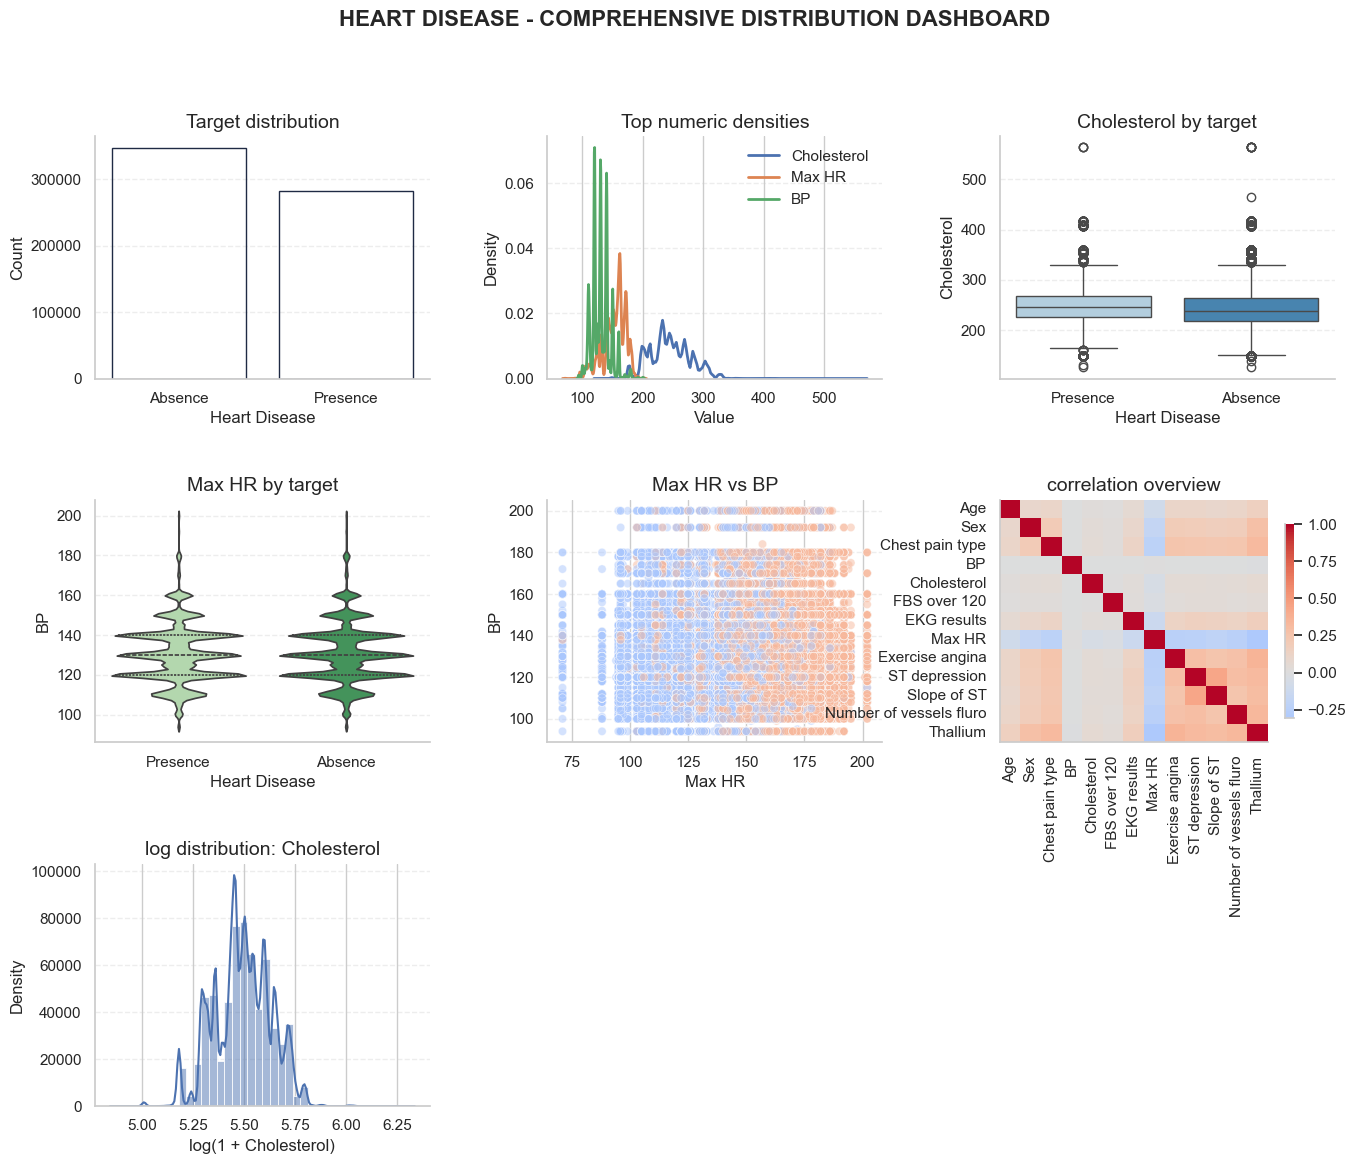

In [8]:
base_numeric_cols = train.select_dtypes(include=["int64", "float64"]).columns.tolist()
base_numeric_cols = [c for c in base_numeric_cols if c not in [target_col, "id"]]

top3 = (
    train[base_numeric_cols].var().sort_values(ascending=False).head(3).index.tolist()
    if len(base_numeric_cols) > 0 else []
)

panels = []

counts = train[target_col].value_counts().sort_index()
if len(counts) > 0:
    panels.append(("Target distribution", "bar_target", counts))

if len(top3) > 0:
    panels.append(("Top numeric densities", "kde_top3", top3))

missing_rates = train.isna().mean().sort_values(ascending=False).head(8)
if (missing_rates > 0).any():
    panels.append(("Top missing rates", "bar missing", missing_rates[missing_rates > 0]))


if len(top3) >= 1:
    panels.append((f"{top3[0]} by target", "box_top1", top3[0]))

if len(top3) >= 2:
    panels.append((f"{top3[1]} by target", "violin_top2", top3[2]))

if len(top3) >= 3:
    panels.append((f"{top3[1]} vs {top3[2]}", "scatter_top23", (top3[1], top3[2])))


if len(base_numeric_cols) >= 2:
    panels.append(("correlation overview", "corr", base_numeric_cols))

if len(top3) >= 1:
    panels.append((f"log distribution: {top3[0]}", "hist_log", top3[0]))


n = len(panels)
n_cols = 3
n_rows = int(np.ceil(n / n_cols))
fig = plt.figure(figsize=(16, 4.2 * n_rows))
gs = fig.add_gridspec(n_rows, n_cols, hspace=0.5, wspace=0.35)

fig.suptitle(
    "HEART DISEASE - COMPREHENSIVE DISTRIBUTION DASHBOARD",
    fontsize=16, fontweight="bold", y=0.98
)

for idx, (title, kind, payload) in enumerate(panels):
    ax = fig.add_subplot(gs[idx // n_cols, idx % n_cols])

    if kind == "bar_target":
        palette = sns.color_palette("Blues", n_colors=len(payload) +2)[2:0]
        sns.barplot(
        x=payload.index.astype(str), y=payload.values,
        hue=payload.index.astype(str), palette=palette,
        ax = ax, edgecolor="#1f2a44", legend=False
        )
        ax.set_xlabel("Heart Disease")
        ax.set_ylabel("Count")

    elif kind == "kde_top3":
        for col in payload:
            sns.kdeplot(train[col], ax=ax, linewidth=2, label=col)
        ax.set_xlabel("Value")
        ax.set_ylabel("Density")
        ax.legend(frameon=False)

    elif kind == "bar_missing":
        sns.barplot(
            x=payload.index, y=paload.values,
            hue=payload.index, palette="purples",
            ax=ax, edgecolor="#1f2a44", legend=False
        )
        ax.set_xlabel("")
        ax.set_ylabel("rate")
        ax.tick_params(axis="x", rotation=45, labelsize=9)

    elif kind == "box_top1":
        sns.boxplot(
            data=train, x=target_col, y=payload,
            hue=train[target_col], palette="Blues",
            ax=ax, legend=False
        )
        ax.set_xlabel("Heart Disease")
        ax.set_ylabel(payload)

    elif kind == "violin_top2":
        sns.violinplot(
            data=train, x=target_col, y=payload,
            hue=train[target_col], palette="Greens",
            ax=ax, inner="quartils", legend=False
        )
        ax.set_xlabel("Heart Disease")
        ax.set_ylabel(payload)


    elif kind == "scatter_top23":
        xcol, ycol = payload
        sns.scatterplot(
            data=train, x=xcol, y=ycol,
            hue=target_col, palette="coolwarm",
            alpha=0.5, ax=ax, legend=False
        )
        ax.set_xlabel(xcol)
        ax.set_ylabel(ycol)

    elif kind == "corr":
        corr = train[payload].corr(numeric_only=True)
        sns.heatmap(corr, cmap="coolwarm", center=0, ax=ax, cbar_kws={"shrink": 0.8})

    elif kind == "hist_log":
        sns.histplot(np.log1p(train[payload]), bins=40, kde=True, ax=ax, color="#4c72b0")
        ax.set_xlabel(f"log(1 + {payload})")
        ax.set_ylabel("Density")

    ax.set_title(title)
    ax.grid(axis="y", linestyle="--", alpha=0.35)

for j in range(idx + 1 , n_rows * n_cols):
    fig.add_subplot(gs[j // n_cols, j % n_cols]).axis("off")

sns.despine()
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
    

In [9]:
categorical_cols = train.select_dtypes(include=["object", "category"]).columns.tolist()

for col in categorical_cols:
    top = train[col].value_counts().head(10)
    display(top)

Heart Disease
Absence     347546
Presence    282454
Name: count, dtype: int64

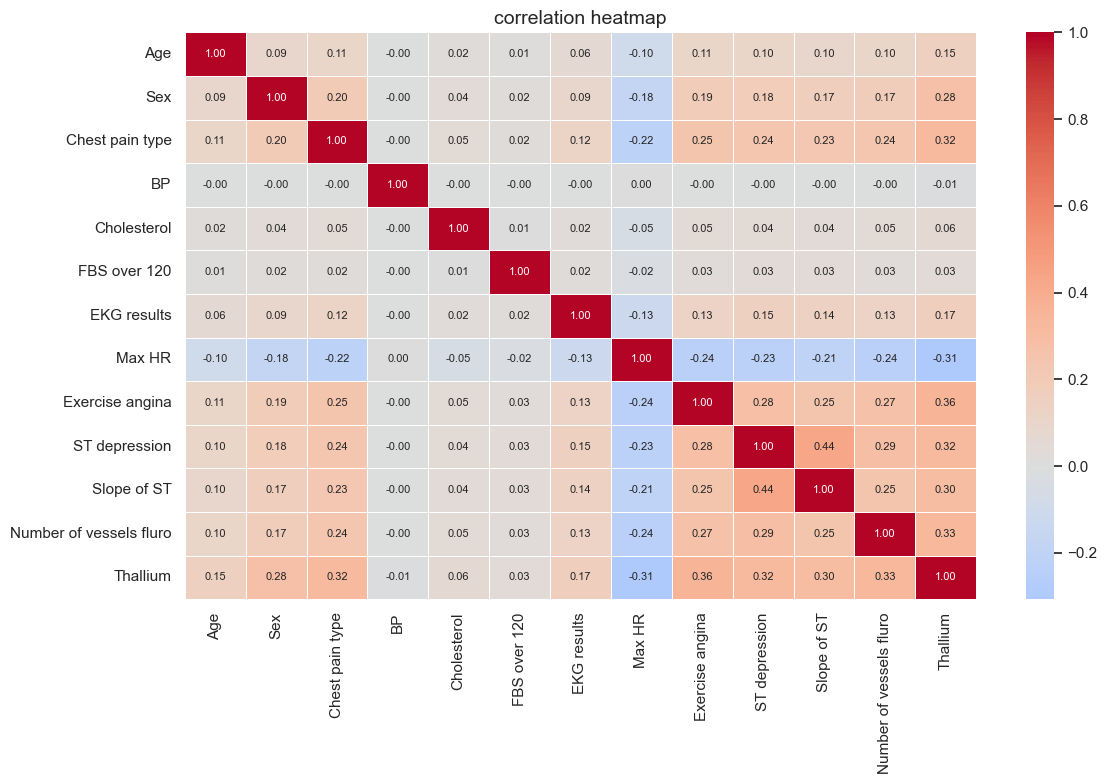

In [10]:
numeric_cols = train.select_dtypes(include=["int64", "float64"]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c not in [id_col]]

corr_df = train[numeric_cols].copy()

if pd.api.types.is_numeric_dtype(train[target_col]):
    corr_df[target_col] = train[target_col]

corr = corr_df.corr(numeric_only=True)

plt.figure(figsize=(12, 8))
sns.heatmap(
    corr,
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    annot=True,
    fmt=".2f",
    annot_kws={"size": 8}
)
plt.title("correlation heatmap")
plt.tight_layout()
plt.show()

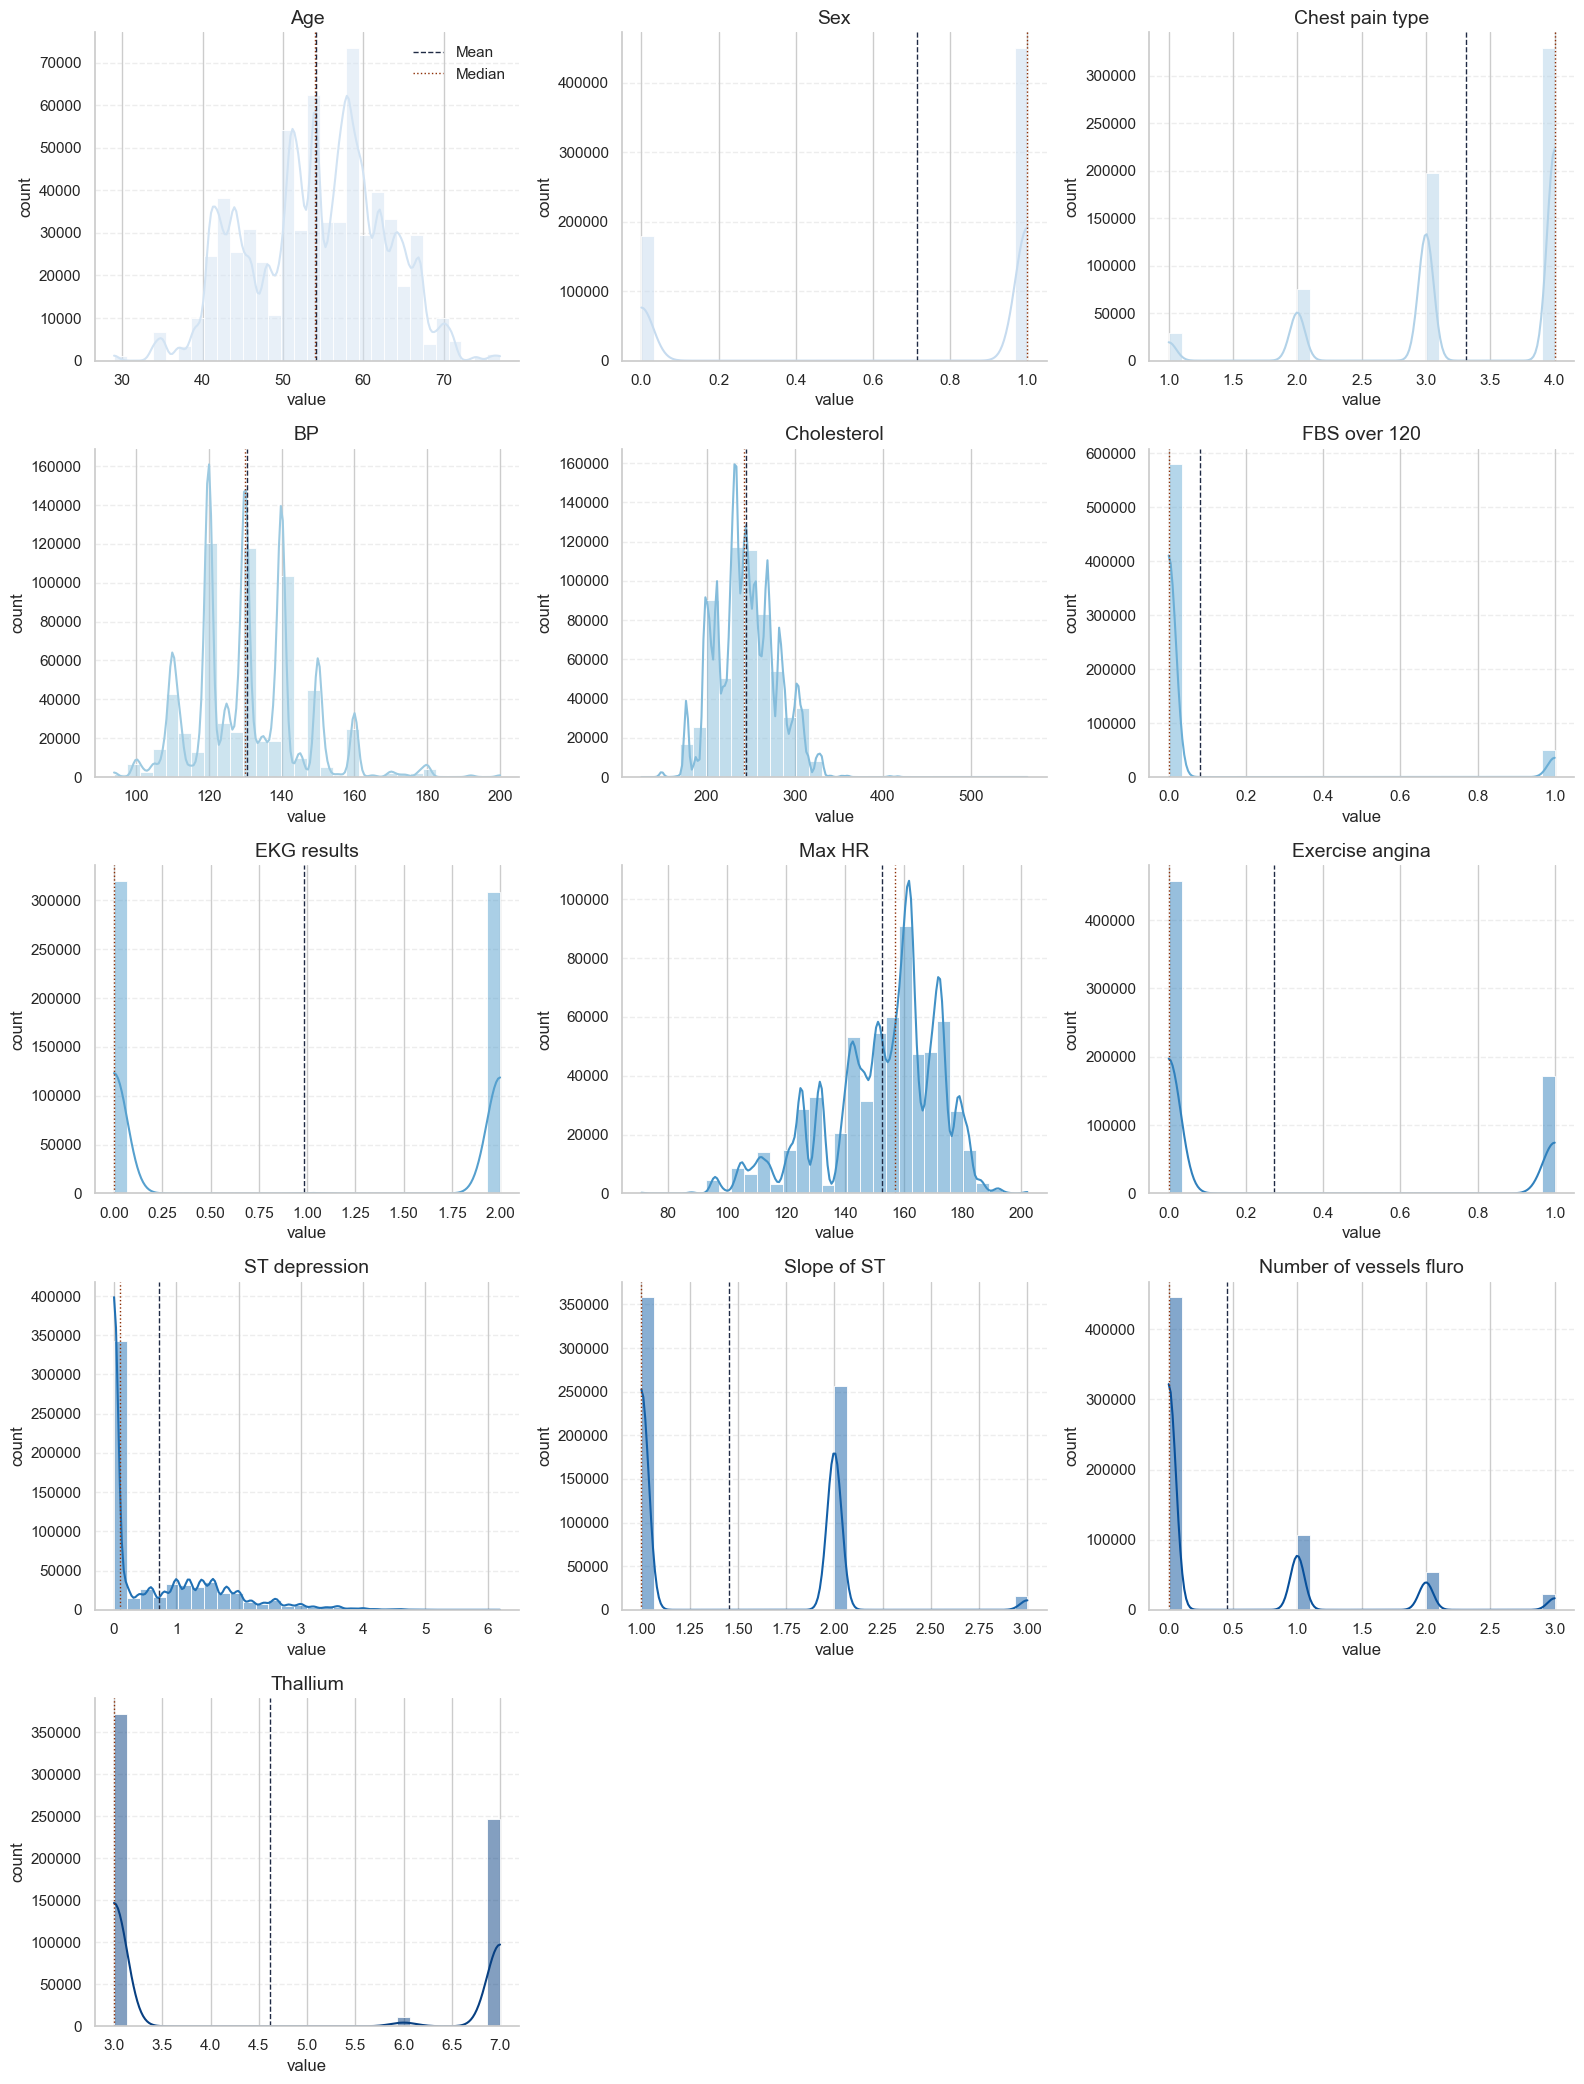

In [11]:
numeric_cols = train.select_dtypes(include=["int64", "float64"]).columns.tolist()
numeric_cols = [ c for c in numeric_cols if c not in [target_col, id_col]]

n_cols = 3
n_rows = int(np.ceil(len(numeric_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4.2 * n_rows))
axes = np.array(axes).reshape(-1)

palette = sns.color_palette("Blues", n_colors=len(numeric_cols) + 2)[2:]

for i, col in enumerate(numeric_cols):
    ax = axes[i]
    sns.histplot(
        train[col].dropna(),
        bins=30,
        kde=True,
        ax=ax,
        color=palette[i],
        edgecolor="white",
        linewidth=0.6
    )

    mean_val = train[col].mean()
    median_val = train[col].median()

    ax.axvline(mean_val, color="#1f2a44", linestyle="--", linewidth=1, label="Mean")
    ax.axvline(median_val, color="#8c2d04", linestyle=":", linewidth=1, label="Median")

    ax.set_title(col)
    ax.set_xlabel("value")
    ax.set_ylabel("count")
    ax.grid(axis="y", linestyle="--", alpha=0.35)

    if i == 0:
        ax.legend(frameon=False)
    
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

sns.despine()
plt.tight_layout()
plt.show()

In [12]:
target_col = "Heart Disease"
id_col = "id"

base_numeric_cols = train.select_dtypes(include=["int64", "float64"]).columns.tolist()
base_numeric_cols = [c for c in base_numeric_cols if c not in [target_col, id_col]]

def build_features(df, numeric_cols, bins=None):
    df = df.copy()

    df["num_mean"] = df[numeric_cols].mean(axis=1)
    df["num_std"] = df[numeric_cols].std(axis=1)
    df["num_min"] = df[numeric_cols].min(axis=1)
    df["num_max"] = df[numeric_cols].max(axis=1)
    df["num_median"] = df[numeric_cols].median(axis=1)
    df["num_sum"] = df[numeric_cols].sum(axis=1)

    for col in numeric_cols:
        df[f"{col}_log1p"] = np.log1p(np.maximum(df[col], 0))
        df[f"{col}_isna"] = df[col].isna().astype(int)

    if bins is None:
        var_order = pd.Series(df[numeric_cols].var()).sort_values(ascending=False)
        top_cols = var_order.head(3).index.tolist()
        bins={}
        for col in top_cols:
            try:
                _, bin_edges = pd.qcut(df[col], q=5, retbins=True, duplicates="drop")
                bins[col] = bin_edges
            except ValueError:
                continue

    if bins:
            for col, edges in bins.items():
                df[f"{col}_bin"] = pd.cut(df[col], bins=edges, include_lowest=True)

    return df, bins

train_fe, fe_bins = build_features(train, base_numeric_cols)
test_fe, _ = build_features(test, base_numeric_cols, bins=fe_bins)

train_fe.head()

,id,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,...,ST depression_isna,Slope of ST_log1p,Slope of ST_isna,Number of vessels fluro_log1p,Number of vessels fluro_isna,Thallium_log1p,Thallium_isna,Cholesterol_bin,Max HR_bin,BP_bin
0,0,58,1,4,152,239,0,0,158,1,...,0,1.098612,0,1.098612,0,2.079442,0,"(234.0, 250.0]","(152.0, 161.0]","(140.0, 200.0]"
1,1,52,1,1,125,325,0,2,171,0,...,0,0.693147,0,0.000000,0,1.386294,0,"(273.0, 564.0]","(170.0, 202.0]","(120.0, 126.0]"
2,2,56,0,2,160,188,0,2,151,0,...,0,0.693147,0,0.000000,0,1.386294,0,"(125.999, 212.0]","(140.0, 152.0]","(140.0, 200.0]"
3,3,44,0,3,134,229,0,2,150,0,...,0,1.098612,0,0.000000,0,1.386294,0,"(212.0, 234.0]","(140.0, 152.0]","(130.0, 140.0]"
4,4,58,1,4,140,234,0,2,125,1,...,0,1.098612,0,1.386294,0,1.386294,0,"(212.0, 234.0]","(70.999, 140.0]","(130.0, 140.0]"


In [18]:
x = train_fe.drop(columns=[target_col, id_col])
y = train_fe[target_col]

x_test = test_fe.drop(columns=[id_col])

numeric_features = x.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = x.select_dtypes(include=["object", "category"]).columns.tolist()

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

logit_preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median"))
        ]), numeric_features),
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), categorical_features)
    ]
)

hgb_preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median"))
        ]), numeric_features),
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ordinal", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
        ]), categorical_features)
    ], sparse_threshold=0.0
)

logit_pipe = Pipeline(steps=[
    ("preprocess", logit_preprocess),
    ("model", LogisticRegression(max_iter=400, solver="liblinear"))
])

hgb_pipe = Pipeline(steps=[
    ("preprocess", hgb_preprocess),
    ("model", HistGradientBoostingClassifier(random_state=42))
])

In [20]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

x_train, x_val, y_train, y_val = train_test_split(
    x, y, test_size=0.2, stratify=y, random_state=42
)

logit_params = {"model__C": [0.1, 1.0]}

hgb_params = {
    "model__learning_rate": [0.1],
    "model__max_depth": [3],
}

print("Fast-tuning Logistic Regression ...")
logit_search = RandomizedSearchCV(
    logit_pipe,
    logit_params,
    n_iter=1,
    scoring="roc_auc",
    cv=2,
    n_jobs=-1,
    random_state=42,
    verbose=0
)
logit_search.fit(x_train, y_train)

print("Fast-tuning HistGradientBoosting ...")
hgb_search = RandomizedSearchCV(
    hgb_pipe,
    hgb_params,
    n_iter=1,
    scoring="roc_auc",
    cv=2,
    n_jobs=-1,
    random_state=42,
    verbose=0
)

hgb_search.fit(x_train, y_train)

logit_best = {
    "c": logit_search.best_params_.get("model__C", "defualt"),
    "score": logit_search.best_score_
}

hgb_best = {
    "learning_rate": hgb_search.best_params_.get("model__learning_rate", "defualt"),
    "max_depth": hgb_search.best_params_.get("model__max_depth", "defualt"),
    "score": hgb_search.best_score_
}

print(f"\nLogistic Regression best: c={logit_best["c"]}, AUC={logit_best["score"]:.4f}")
print(f"HistgradientBoosting best: lr={hgb_best["learning_rate"]}, depth={hgb_best["max_depth"]}, AUC={hgb_best["score"]:.4f}")

logit_val_score = logit_search.score(x_val, y_val)
hgb_val_score = hgb_search.score(x_val, y_val)
print(f"\nValidation AUC - Logistic: {logit_val_score: .4f}, HGB: {hgb_val_score:.4f}")

Fast-tuning Logistic Regression ...
Fast-tuning HistGradientBoosting ...

Logistic Regression best: c=1.0, AUC=0.9521
HistgradientBoosting best: lr=0.1, depth=3, AUC=0.9538

Validation AUC - Logistic:  0.9533, HGB: 0.9548


In [23]:
comparison = pd.DataFrame({
    "model": ["LogisticRegression (tuned)", "HistGradientBoosting (tuned"],
    "cv_mean_auc": [logit_search.best_score_, hgb_search.best_score_]
}).sort_values("cv_mean_auc", ascending=False)

comparison

,model,cv_mean_auc
1,HistGradientBoosting (tuned,0.953801
0,LogisticRegression (tuned),0.952112


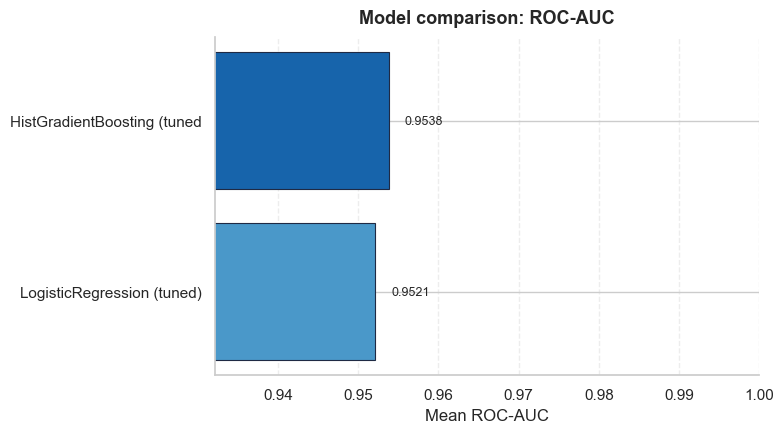

In [29]:
fig, ax = plt.subplots(figsize=(8, 4.5))

comp = comparison.sort_values("cv_mean_auc", ascending=True)
colors = sns.color_palette("Blues", n_colors=len(comp) + 2)[2:]

bars = ax.barh(comp["model"], comp["cv_mean_auc"], color=colors, edgecolor="#1f2a44", linewidth=0.8)

ax.set_title("Model comparison: ROC-AUC", pad=10, fontsize=13, fontweight="bold")
ax.set_xlabel("Mean ROC-AUC")
ax.set_ylabel("")
ax.set_xlim(max(0.5, comp["cv_mean_auc"].min() -0.02), 1.0)
ax.grid(axis="x", linestyle="--", alpha=0.35)
ax.set_axisbelow(True)

for b in bars:
    w = b.get_width()
    ax.text(w + 0.002, b.get_y() + b.get_height()/2, f"{w:.4f}", va="center", fontsize=9)

sns.despine()
plt.tight_layout()
plt.show()

In [31]:
best_model = logit_search.best_estimator_
best_name = "LogisticRegression (tuned)"

if hgb_search.best_score_ > logit_search.best_score_:
    best_model = hgb_search.best_estimator_
    best_name = "HistGradientBoosting(tuned)"

print(f"Selected model: {best_name}")

best_model.fit(x, y)
test_pred = best_model.predict_proba(x_test)[:, 1]

submission = pd.DataFrame({
    id_col: test[id_col],
    target_col: test_pred
})

submission.to_csv("submission.csv", index=False)
submission.head()

Selected model: HistGradientBoosting(tuned)


,id,Heart Disease
0,630000,0.859297
1,630001,0.008950
2,630002,0.980313
3,630003,0.006029
4,630004,0.271729
